# Trafic Sign Vision Transformer
This notebook referred to the following notebook.<br/>
https://www.kaggle.com/szuzhangzhi/vision-transformer-vit-cuda-as-usual

In [1]:
!pip install vision_transformer_pytorch

In [2]:
import sys
package_path = '../input/vision-transformer-pytorch/VisionTransformer-Pytorch'
sys.path.append(package_path)

In [3]:
import os
import pandas as pd

import time
import datetime
import copy
import matplotlib.pyplot as plt
import json
import seaborn as sns
import cv2
import albumentations as albu
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split


# ALBUMENTATIONS
import albumentations as albu

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
    
from albumentations.pytorch import ToTensorV2

# ADAMP
# from adamp import AdamP

In [4]:
BASE_DIR="../input/gtsrb-german-traffic-sign"
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR,'Test')

In [5]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## Target: ClassId

In [6]:
class_name = train_df['ClassId'].value_counts().index       #target name
class_count = train_df['ClassId'].value_counts().values

In [7]:
train_df.ClassId.value_counts()       #target name

2     750
1     720
13    720
38    690
12    690
4     660
10    660
5     630
9     480
25    480
3     450
8     450
7     450
11    420
35    390
18    390
17    360
31    270
14    270
15    210
33    210
26    180
30    150
16    150
28    150
6     150
23    150
22    120
36    120
34    120
24     90
29     90
20     90
40     90
21     90
39     90
42     90
32     60
27     60
41     60
19     60
0      60
37     60
Name: ClassId, dtype: int64

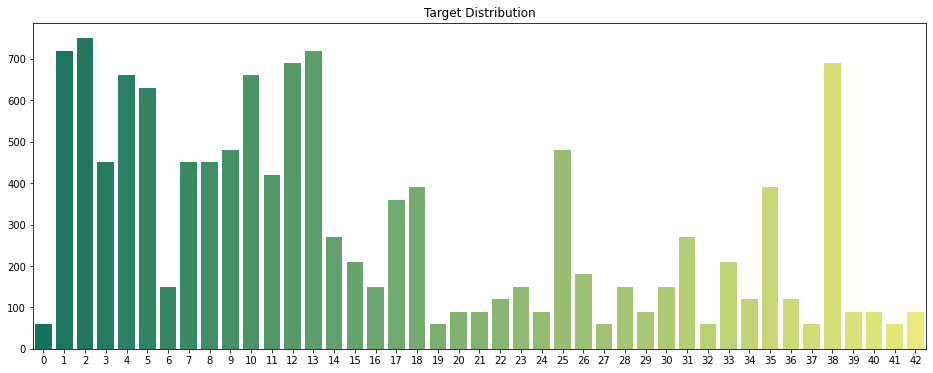

In [8]:
# Counting target values.

targ_cts=train_df.ClassId.value_counts()    #target name
fig = plt.figure(figsize=(16,6))
sns.barplot(x=targ_cts.sort_values(ascending=False).index, 
            y=targ_cts.sort_values(ascending=False).values, 
            palette='summer')
plt.title('Target Distribution')
plt.show()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(train_df.pollen_carrying)
train_df['pollen_carrying'] = le.transform(train_df.pollen_carrying)

In [9]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for idx, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx+1)
        
        image = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
        
    plt.show()
    

def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(os.path.join(TRAIN_IAMGES_DIR, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    x = transform(image=img)['image']
    plt.imshow(x)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    x = transform(image=img)['image']
    plt.imshow(x)
    
def visualize(images, transform):
    '''
    Plot images and their transformations
    '''
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

<class 'numpy.ndarray'>
True


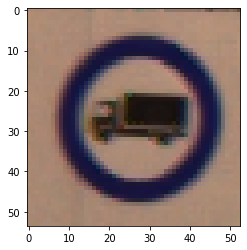

In [10]:
img0=cv2.imread('../input/gtsrb-german-traffic-sign/Test/00000.png')
print(type(img0))
print(type(img0)==np.ndarray)
plt.imshow(img0)

In [26]:
# CUSTOM DATASET CLASS
class PlantDataset(Dataset):
    def __init__(
        self, df:pd.DataFrame, imfolder:str, train:bool=True, transforms=None
    ):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['Path'])
#         print(im_path)  
        im = cv2.imread(im_path, cv2.IMREAD_COLOR)
#         print(type(im))       
        if type(im)==np.ndarray:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            if (self.transforms):
                '''
                When AlbumentationCompose, a dictionary with key 'image' is created
                '''
                im = self.transforms(image=im)['image']

            if (self.train):
                label = self.df.iloc[index]['ClassId']    #target name
                return im, label
            else:
                return im

In [27]:
# AUGMENTATIONS

train_augs = albu.Compose([
    albu.RandomResizedCrop(height=384, width=384, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.3, 0.3, 0.3],
        std=[0.1, 0.1, 0.1],),
    CoarseDropout(p=0.5),
    Cutout(p=0.5),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=384, width=384, p=1.0),
    albu.Normalize(
        mean=[0.3, 0.3, 0.3],
        std=[0.1, 0.1, 0.1],),
    ToTensorV2(),
])


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [28]:
# DATA SPLIT
train, valid = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df.ClassId.values    #target name
)

# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# targets in train,valid datasets
train_targets = train.ClassId.values    #target name
valid_targets = valid.ClassId.values

In [29]:
# DEFINE PYTORCH CUSTOM DATASET
train_dataset = PlantDataset(
    df = train,
    imfolder = BASE_DIR,
    #imfolder = TRAIN_IMAGES_DIR,
    train = True,
    transforms = train_augs
)

valid_dataset = PlantDataset(
    df = valid,
    imfolder = BASE_DIR,
    #imfolder = TRAIN_IMAGES_DIR,
    train=True,
    transforms = valid_augs
)

In [30]:
def plot_image(img_dict):
    image_tensor = img_dict[0]
    target = img_dict[1]
    image = image_tensor.permute(1, 2, 0)
    image2=image.numpy()
    if type(image2)==np.ndarray:
        plt.imshow(image2)

In [31]:
train_dataset[6]

(tensor([[[0.2549, 0.2941, 0.3333,  ..., 0.6078, 0.5686, 0.4902],
          [0.2549, 0.3333, 0.3725,  ..., 0.6471, 0.6078, 0.5294],
          [0.2941, 0.3725, 0.4118,  ..., 0.6471, 0.6078, 0.5686],
          ...,
          [1.4314, 1.3529, 1.2745,  ..., 7.0000, 7.0000, 7.0000],
          [1.5098, 1.4314, 1.3529,  ..., 7.0000, 7.0000, 7.0000],
          [1.5490, 1.5098, 1.4314,  ..., 7.0000, 7.0000, 7.0000]],
 
         [[0.6078, 0.6863, 0.7255,  ..., 0.8824, 0.8431, 0.8039],
          [0.6471, 0.6863, 0.7255,  ..., 0.9216, 0.8824, 0.8039],
          [0.6863, 0.7255, 0.7647,  ..., 0.9216, 0.8824, 0.8431],
          ...,
          [1.9412, 1.8627, 1.7843,  ..., 7.0000, 7.0000, 7.0000],
          [1.9804, 1.9020, 1.8627,  ..., 7.0000, 7.0000, 7.0000],
          [2.0196, 1.9412, 1.9020,  ..., 7.0000, 7.0000, 7.0000]],
 
         [[0.7255, 0.7647, 0.8039,  ..., 0.7255, 0.6471, 0.6078],
          [0.7255, 0.8039, 0.8431,  ..., 0.6863, 0.6078, 0.5294],
          [0.7647, 0.8039, 0.8431,  ...,

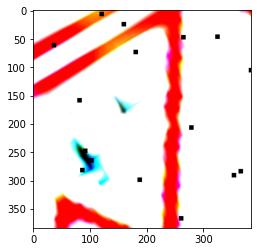

In [32]:
plot_image(train_dataset[6])

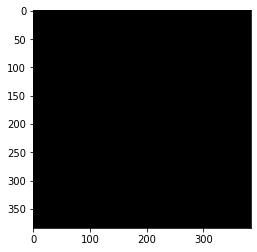

In [33]:
plot_image(train_dataset[10])

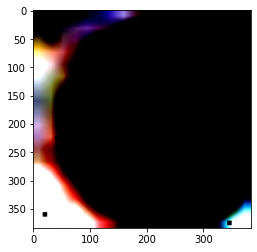

In [34]:
plot_image(train_dataset[13])

In [35]:
# MAKE PYTORCH DATALOADER
train_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    num_workers = 4,
    shuffle = True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size = 4,
    num_workers = 4,
    shuffle = False
)

In [36]:
# TRAIN
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
               
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [37]:
from vision_transformer_pytorch import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}

# LOAD PRETRAINED ViT MODEL
model = VisionTransformer.from_pretrained('ViT-B_16', num_classes=43)      ###      

# OPTIMIZER
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer = AdamP(model.parameters(), lr=1e-4, weight_decay=0.001)

# LEARNING RATE SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

criterion = nn.CrossEntropyLoss()
num_epochs = 4

cuda
Loaded pretrained weights for ViT-B_16


In [38]:
# MODEL TRAIN
trained_model = train_model(datasets, dataloaders, model, 
                            criterion, optimizer, scheduler, 
                            num_epochs, device)

Epoch 0/3
----------
train Loss: 1.5333 Acc: 0.5430
valid Loss: 0.4805 Acc: 0.8504

Epoch 1/3
----------
train Loss: 0.6525 Acc: 0.7951
valid Loss: 0.1784 Acc: 0.9422

Epoch 2/3
----------
train Loss: 0.3003 Acc: 0.9077
valid Loss: 0.0251 Acc: 0.9945

Epoch 3/3
----------
train Loss: 0.2328 Acc: 0.9295
valid Loss: 0.0189 Acc: 0.9968

Training complete in 62m 1s
Best val Acc: 0.9968


In [50]:
# Save the mode after training
torch.save(model.state_dict(), 'ViT_modelDict.pt')
torch.save(model, 'ViT_model.pt')

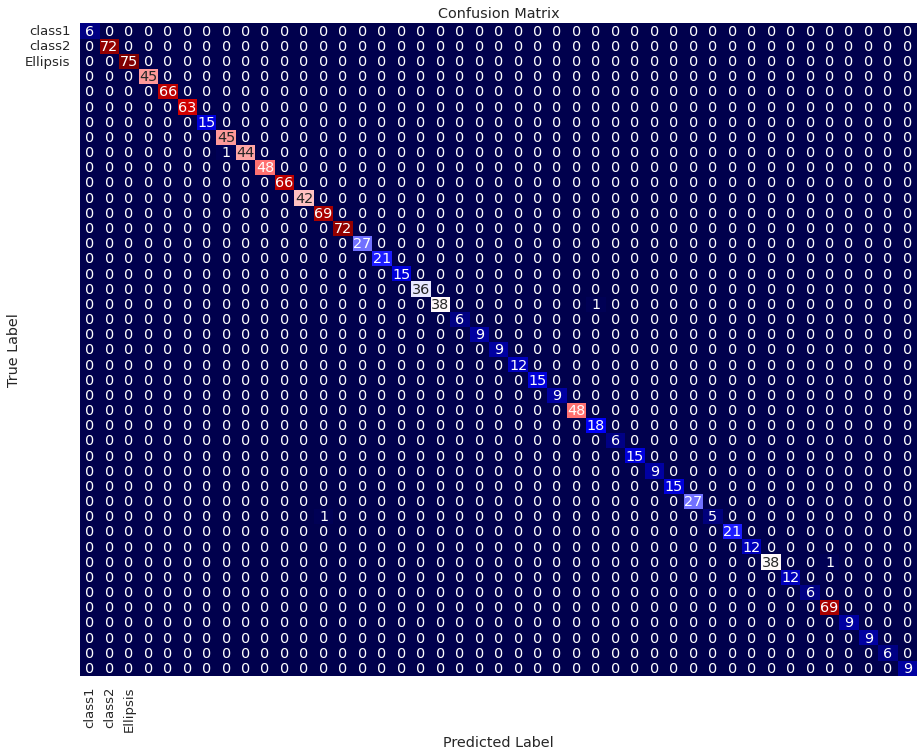


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        72
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        66
           5       1.00      1.00      1.00        63
           6       1.00      1.00      1.00        15
           7       0.98      1.00      0.99        45
           8       1.00      0.98      0.99        45
           9       1.00      1.00      1.00        48
          10       1.00      1.00      1.00        66
          11       1.00      1.00      1.00        42
          12       0.99      1.00      0.99        69
          13       1.00      1.00      1.00        72
          14       1.00      1.00      1.00        27
          15       1.00      1.00      1.00        21
          16       1.00      1.00      1.00        15
   

In [49]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    confusion = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    
    return confusion, class_report

# Assuming `valid_loader` is your validation dataloader
confusion_matrix, classification_report = evaluate_model(model, dataloaders['valid'], device)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(15, 12))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="seismic", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Assuming `class_names` contains the names of your classes
class_names = ['class1', 'class2', ...]  # Replace with your actual class names
plot_confusion_matrix(confusion_matrix, class_names)

print("\nClassification Report:")
print(classification_report)


In [71]:
#dictionary to label all traffic signs class.
classes = { 1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)', 
            3:'Speed limit (50km/h)', 
            4:'Speed limit (60km/h)', 
            5:'Speed limit (70km/h)', 
            6:'Speed limit (80km/h)', 
            7:'End of speed limit (80km/h)', 
            8:'Speed limit (100km/h)', 
            9:'Speed limit (120km/h)', 
            10:'No passing', 
            11:'No passing veh over 3.5 tons', 
            12:'Right-of-way at intersection', 
            13:'Priority road', 
            14:'Yield', 
            15:'Stop', 
            16:'No vehicles', 
            17:'Veh > 3.5 tons prohibited', 
            18:'No entry', 
            19:'General caution', 
            20:'Dangerous curve left', 
            21:'Dangerous curve right', 
            22:'Double curve', 
            23:'Bumpy road', 
            24:'Slippery road', 
            25:'Road narrows on the right', 
            26:'Road work', 
            27:'Traffic signals', 
            28:'Pedestrians', 
            29:'Children crossing', 
            30:'Bicycles crossing', 
            31:'Beware of ice/snow',
            32:'Wild animals crossing', 
            33:'End speed + passing limits', 
            34:'Turn right ahead', 
            35:'Turn left ahead', 
            36:'Ahead only', 
            37:'Go straight or right', 
            38:'Go straight or left', 
            39:'Keep right', 
            40:'Keep left', 
            41:'Roundabout mandatory', 
            42:'End of no passing', 
            43:'End no passing veh > 3.5 tons' }


Predicted: 26 Traffic signals
label:  26 Traffic signals
picture:


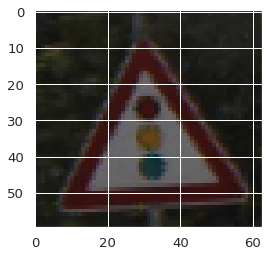


Predicted: 5 Speed limit (80km/h)
label:  5 Speed limit (80km/h)
picture:


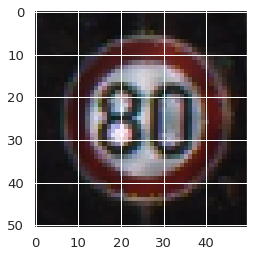


Predicted: 5 Speed limit (80km/h)
label:  5 Speed limit (80km/h)
picture:


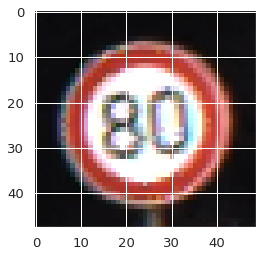


Predicted: 4 Speed limit (70km/h)
label:  4 Speed limit (70km/h)
picture:


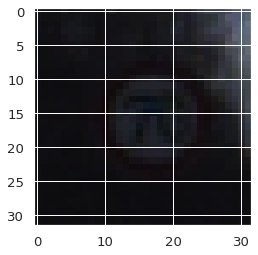


Predicted: 4 Speed limit (70km/h)
label:  4 Speed limit (70km/h)
picture:


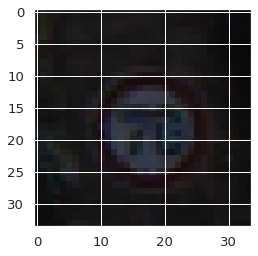


Predicted: 39 Keep left
label:  39 Keep left
picture:


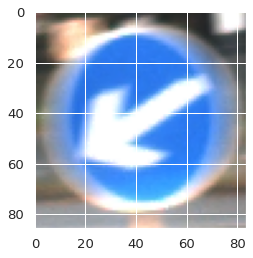


Predicted: 12 Priority road
label:  12 Priority road
picture:


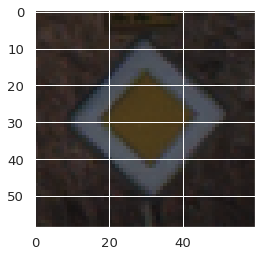


Predicted: 1 Speed limit (30km/h)
label:  1 Speed limit (30km/h)
picture:


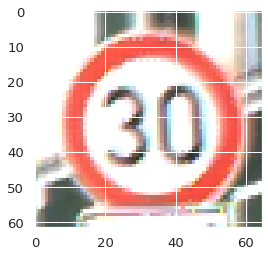


Predicted: 18 General caution
label:  18 General caution
picture:


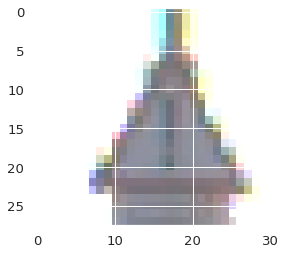


Predicted: 15 No vehicles
label:  15 No vehicles
picture:


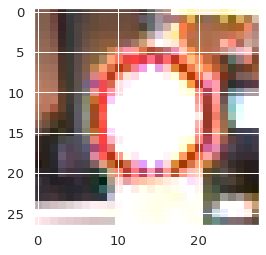

In [117]:

# Load the saved model
model = torch.load('ViT_model.pt', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Specify device if not on CPU
# model

valid_dataset_show = PlantDataset(
    df = valid,
    imfolder = BASE_DIR,
    #imfolder = TRAIN_IMAGES_DIR,
    train=False
)





# pic_ind = 22

for i in range(10):
    pic_ind = 5 * i

    print()

    
    vsingle_inputs = valid_dataset[pic_ind][0].unsqueeze(0)  # Add a batch dimension at index 0
    vsingle_inputs = vsingle_inputs.to(device)  # Move input tensor to the same device as the model
    _, single_preds = torch.max(model(vsingle_inputs), 1)
    print('Predicted:', single_preds.item() , classes[single_preds.item()+1])
    print('label: ' , valid_dataset[pic_ind][1] ,classes[valid_dataset[pic_ind][1]+1])

    print('picture:')
    plt.imshow(valid_dataset_show[pic_ind])
    plt.show()